In [1]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations, product
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
from decorators import *
from smartprint import smartprint as sprint
from scipy.spatial.distance import cdist
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

embmatched_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/embmatched_id_maps'
os.makedirs(embmatched_id_map_data_dir, exist_ok=True)

in_session_median_embeddings_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/in_session_median_embeddings'
os.makedirs(in_session_median_embeddings_data_dir, exist_ok=True)

in_session_cluster_embeddings_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/in_session_cluster_embeddings'
os.makedirs(in_session_cluster_embeddings_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_tracking/session_matching_info'
os.makedirs(id_viz_cache_root, exist_ok=True)

/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [20]:
session = 'classinsight-cmu_05748A_ghc_4101_201902141630'
course = '05748A'

In [21]:
session_frame_dir = f'{base_dir}/{course}/{session}-front'

## Get embedding and gaze information for all frames for all sessions (Run if needed, commented out for now)?

## Get frame file data for all sessions

In [22]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
        
frame_file_data.keys()

dict_keys(['05748A', '05410B', '17214C', '17214B', '05681A', '24352A', '24352C', '86375A'])

In [23]:
# writing a generic loop to get embedding info from all courses in frame file data
emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info'
os.makedirs(emb_analysis_session_data,exist_ok=True)

for course_idx, course in enumerate(frame_file_data):
    for session_idx, session_id in enumerate(frame_file_data[course]):
        session_emb_cache_file = f"{emb_analysis_session_data}/{session_id}.pb"
        try:
            if not os.path.exists(session_emb_cache_file):
                session_dir = frame_file_data[course][session_id]['dir_location']
                frame_ids = frame_file_data[course][session_id]['frame_ids']
                session_emb_info = {}
                for frame_id in frame_ids:
                    frame_number, frame_data = pickle.load(open(f'{session_dir}/{frame_id}.pb','rb'))
                    frame_emb_info = {int(person_info['track_id']):{
                        'bbox': person_info['bbox'] if 'bbox' in person_info else None,
                        'rvec': person_info['rvec'] if 'rvec' in person_info else None,
                        'gaze_2d':person_info['gaze_2d'] if 'gaze_2d' in person_info else None,
                        'face_embedding': person_info['face_embedding'] if 'face_embedding' in person_info else None,
                    } for person_info in frame_data}
                    session_emb_info[frame_id] = frame_emb_info
                pickle.dump(session_emb_info, open(session_emb_cache_file,'wb'))
                print(f"Got emb info for session: {course_idx}-{course}, session:{session_idx}-{session_id}")
            else:
                ...
                print(f"FILE EXISTS: emb info for session: {course_idx}-{course}, session:{session_idx}-{session_id}")
        except:
            print(f"ERROR: Unable to get session emb for: {course_idx}-{course}, session:{session_idx}-{session_id}")
            unfinished_sessions.append((course, session_id))
            print(traceback.format_exc())
    

FILE EXISTS: emb info for session: 0-05748A, session:0-classinsight-cmu_05748A_ghc_4101_201902051630-front
FILE EXISTS: emb info for session: 0-05748A, session:1-classinsight-cmu_05748A_ghc_4101_201902141630-front
ERROR: Unable to get session emb for: 0-05748A, session:2-classinsight-cmu_05748A_ghc_4101_201901291630-front



KeyboardInterrupt



In [24]:
session_emb_info = pickle.load(open(f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info/{session}-front.pb','rb'))
session_id_map = pickle.load(open(f"{postprocessed_id_map_data_dir}/{session}-front.pb","rb"))
df_tracking_new = pickle.load(open(f"{track_analysis_session_data}/{session}-front.pb","rb")).transpose()

# Replace raw ids with mapped ids for given session
session_emb_info = {
    xr:{
        session_id_map[yr]:session_emb_info[xr][yr] 
            for yr in session_emb_info[xr] if not (session_id_map[yr]==10000)} for xr in session_emb_info}

### Get id start stop for given session

In [25]:
total_idxs = df_tracking_new.index.max()
for old_id in session_id_map:
    new_id = session_id_map[old_id]
    if not new_id==10000:
        new_id_col = f'N{new_id}'
        if new_id_col not in df_tracking_new:
            df_tracking_new[new_id_col] = None
        df_tracking_new[new_id_col] =  df_tracking_new[old_id].where(~df_tracking_new[old_id].isnull(), df_tracking_new[old_id])
    df_tracking_new = df_tracking_new.drop(old_id, axis=1)

col_start_stop_idxs = []
for col in df_tracking_new.columns:
    one_idxs = df_tracking_new.index[np.where(df_tracking_new[col]==1)[0]].values
    col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
df_id_start_stop['id'] = df_id_start_stop['id'].apply(lambda x: int(x[1:]))
df_id_start_stop

,id,min_idx,max_idx,total_idxs
0,0,0,71736,71736
1,1,0,71736,71736
2,2,60147,62745,2598
3,3,14067,53865,39798
4,4,0,71736,71736
5,5,0,71736,71736
6,6,40623,71736,31113
7,7,0,52224,52224
8,8,2583,71736,69153
9,9,62148,71736,9588


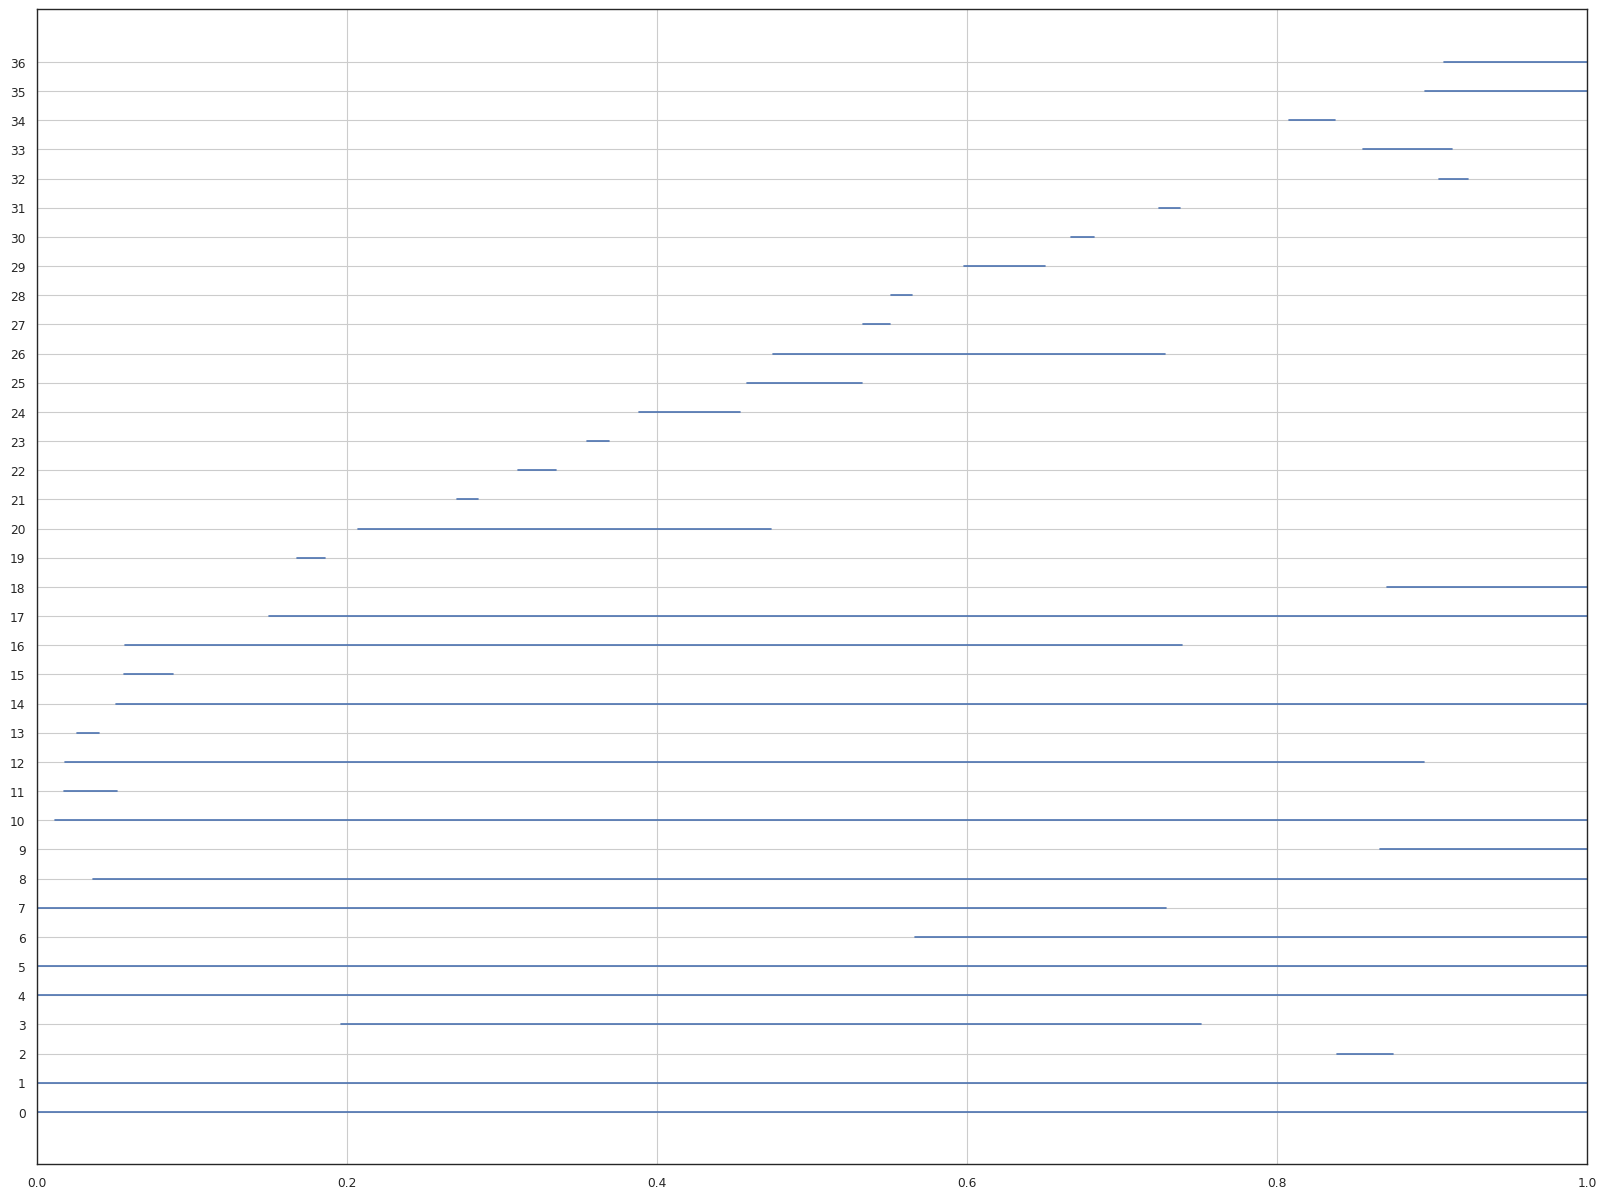

In [26]:
_ = plt.figure(figsize=(20,15))
for row_idx, row in df_id_start_stop.iterrows():
    plt.axhline(y=row_idx, xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs)
plt.yticks(range(df_id_start_stop.shape[0]), range(df_id_start_stop.shape[0]))
plt.grid() 

In [27]:
# arrange info as per tracking id across both sessions
# pitch, roll, yaw= session_emb_info[0][9]['rvec'][0]
gaze_info = {}
emb_info = {}
bbox_info = {}

for frame_number in session_emb_info:
    for trackId in session_emb_info[frame_number]:
        if trackId not in gaze_info:
            gaze_info[trackId] = []
            emb_info[trackId]=[]
            bbox_info[trackId] = []
        # get  gaze info
        try:
            id_bbox = session_emb_info[frame_number][trackId]['bbox']
            bbox_info[trackId].append([frame_number]+list(id_bbox))
            pitch, roll, yaw= session_emb_info[frame_number][trackId]['rvec'][0]
            pitch, roll, yaw=np.rad2deg(pitch), np.rad2deg(roll), np.rad2deg(yaw)
            gaze_sx, gaze_sy, gaze_ex, gaze_ey = session_emb_info[frame_number][trackId]['gaze_2d'][0].flatten()
            gaze_info[trackId].append([frame_number, pitch, roll, yaw, gaze_sx, gaze_sy, gaze_ex, gaze_ey])
            face_emb = session_emb_info[frame_number][trackId]['face_embedding'].tolist()
            emb_info[trackId].append([frame_number]+face_emb)
        except:
            continue

for id in gaze_info:
    gaze_info[id] = pd.DataFrame(gaze_info[id], columns=['frame','pitch','roll','yaw','gaze_sx', 'gaze_sy', 'gaze_ex', 'gaze_ey']).set_index('frame')
    emb_info[id] =pd.DataFrame(emb_info[id], columns=['frame']+np.arange(512).tolist()).set_index('frame')
    bbox_info[id] = pd.DataFrame(bbox_info[id], columns=['frame']+np.arange(5).tolist()).set_index('frame')

len(gaze_info.keys())

37

In [28]:
sprint({xr:(gaze_info[xr].shape[0],emb_info[xr].shape[0], bbox_info[xr].shape[0]) for xr in emb_info})

Dict: {xr:(gaze_info[xr].shape[0],emb_info[xr].shape[0], bbox_info[xr].shape[0]) for xr in emb_info}
Key: Value


{0: (23858, 23858, 23913),
 1: (23871, 23871, 23904),
 2: (20407, 20407, 20916),
 3: (17549, 17549, 17906),
 4: (23891, 23891, 23911),
 5: (23809, 23809, 23913),
 6: (23497, 23497, 23871),
 7: (17329, 17329, 17409),
 8: (23265, 23265, 23790),
 9: (23314, 23314, 23874),
 10: (18783, 18783, 23628),
 11: (777, 777, 822),
 12: (20240, 20240, 20969),
 13: (65, 65, 331),
 14: (22246, 22246, 22669),
 15: (92, 92, 755),
 16: (14917, 14917, 16278),
 17: (19626, 19626, 22457),
 18: (19901, 19901, 19983),
 19: (100, 100, 431),
 20: (6323, 6323, 6375),
 21: (157, 157, 270),
 22: (455, 455, 580),
 23: (272, 272, 351),
 24: (1484, 1484, 1567),
 25: (1573, 1573, 1776),
 26: (5766, 5766, 6047),
 27: (358, 358, 416),
 28: (29, 29, 322),
 29: (1129, 1129, 1242),
 30: (97, 97, 342),
 31: (169, 169, 325),
 32: (1328, 1328, 4042),
 33: (2345, 2345, 3339),
 34: (147, 147, 701),
 35: (2469, 2469, 2507),
 36: (2129, 2129, 2203)}

In [29]:
df_id_start_stop

,id,min_idx,max_idx,total_idxs
0,0,0,71736,71736
1,1,0,71736,71736
2,2,60147,62745,2598
3,3,14067,53865,39798
4,4,0,71736,71736
5,5,0,71736,71736
6,6,40623,71736,31113
7,7,0,52224,52224
8,8,2583,71736,69153
9,9,62148,71736,9588


## Use spectral clustering to get clean set of embeddings, calculate their centroid, and then evaluate distance for non overlapping ids

In [30]:
from sklearn.cluster import DBSCAN
EPS = 0.4
MIN_PTS = 100
DISTANCE_THRESHOLD = 0.2
OVERLAP_THRESHOLD = 0.8

In [31]:

np.random.seed(42)
clustered_median_emb = {}
for id in emb_info:
    emb_clu = DBSCAN(min_samples=MIN_PTS, eps=EPS)
    emb_clu.fit(emb_info[id].values)
    if max(emb_clu.labels_)<0:
        sprint(f"All frames are outliers, not proceeding with id {id}")
        continue
    best_cluster_id = pd.Series(emb_clu.labels_[emb_clu.labels_>=0]).value_counts().index[0]
    frames = emb_info[id].iloc[emb_clu.labels_==best_cluster_id].index.values
    clustered_median_emb[id] = np.median(emb_info[id].loc[frames],axis=0)
    

f"All frames are outliers, not proceeding with id {id}" : All frames are outliers, not proceeding with id 13
f"All frames are outliers, not proceeding with id {id}" : All frames are outliers, not proceeding with id 15
f"All frames are outliers, not proceeding with id {id}" : All frames are outliers, not proceeding with id 19
f"All frames are outliers, not proceeding with id {id}" : All frames are outliers, not proceeding with id 21
f"All frames are outliers, not proceeding with id {id}" : All frames are outliers, not proceeding with id 27
f"All frames are outliers, not proceeding with id {id}" : All frames are outliers, not proceeding with id 28
f"All frames are outliers, not proceeding with id {id}" : All frames are outliers, not proceeding with id 30
f"All frames are outliers, not proceeding with id {id}" : All frames are outliers, not proceeding with id 31


# Get potential visual matches for non overlapping IDs

In [16]:
match_scores = {}
match_info = {}
for idA in sorted(clustered_median_emb.keys()):
    for idB in sorted(clustered_median_emb.keys()):
        if idB in match_scores.keys():
            continue
        # check if idA and idB overlaps, if not, Just leave them be
        min_idxA, max_idxA = df_id_start_stop[df_id_start_stop['id']==idA][['min_idx','max_idx']].values[0].tolist()
        min_idxB, max_idxB = df_id_start_stop[df_id_start_stop['id']==idB][['min_idx','max_idx']].values[0].tolist()
        if len(range(max(min_idxA,min_idxB), min(max_idxA,max_idxB))) > 0:
            #overlapping ranges
            continue
        match_distance = cdist(clustered_median_emb[idA].reshape(1,-1), clustered_median_emb[idB].reshape(1,-1))[0][0]
        if match_distance < DISTANCE_THRESHOLD:
            if idA not in match_scores:
                match_scores[idA] = {}
            match_scores[idA][idB] = 1 - match_distance
        
df_matching_method = pd.DataFrame(match_scores)
df_matching_method.shape    

(4, 4)

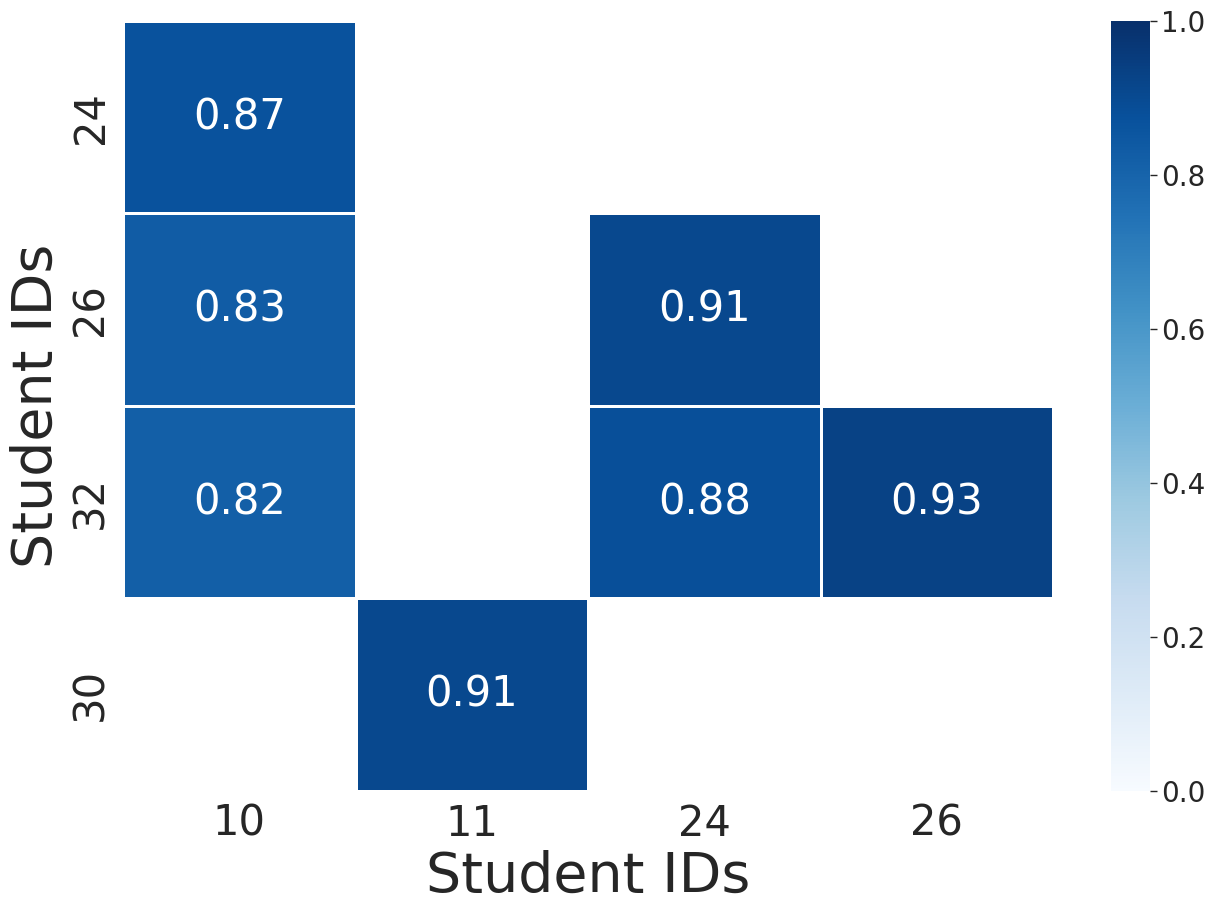

In [17]:
from matplotlib.patches import Rectangle
fig, axn = plt.subplots(1,1,figsize=(15,10))
sns.heatmap(df_matching_method.round(2), annot=True, annot_kws={'fontsize':30},ax=axn,cmap='Blues', vmax=1, vmin=0, linewidths=1)
# for gtA in map(int, gt_map):
#     for gtB in map(int, gt_map[str(gtA)]):
#         if (gtA>=0) and (gtB>=0):
#             if (gtA in df_matching_methodC.columns) and (gtB in df_matching_methodC.index):
#                 locA, locB = df_matching_methodC.columns.get_loc(gtA), df_matching_methodC.index.get_loc(gtB)
#                 axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='red', lw=4))

# for locA in range(df_matching_method.shape[1]):
#     locBs = df_matching_method.iloc[:,locA].argsort()[:1]
#     for locB in locBs:
#         axn.add_patch(Rectangle((locA, locB), 1, 1, fill=False, edgecolor='blue', lw=1))

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
axn.set_xlabel(f"Student IDs",fontsize=40)
axn.set_ylabel(f"Student IDs",fontsize=40)
cbar = axn.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.savefig(f'case_studies/plots/self_match_{course}_{session.split("_")[-1]}.png',dpi=400,bbox_inches='tight')

#### Get Bounding Box overlap for non-overlapping ids

In [32]:
overlap_scores = {}
def bbox_overlap_metric(bu, bv):
    X_TL1, Y_TL1, X_BR1, Y_BR1 = bu[:4]
    p1, p2, p3, p4  = map(Point, [[X_TL1,Y_TL1], [X_TL1,Y_BR1], [X_BR1,Y_BR1],[X_BR1, Y_TL1]]) 
    id_polygon = Polygon(p1, p2, p3, p4)
    X_TL2, Y_TL2, X_BR2, Y_BR2 = bv[:4]
    p1, p2, p3, p4  = map(Point, [[X_TL2,Y_TL2], [X_TL2,Y_BR2], [X_BR2,Y_BR2],[X_BR2, Y_TL2]]) 
    matched_id_polygon = Polygon(p1, p2, p3, p4)
    if id_polygon.encloses_point(matched_id_polygon.centroid) & matched_id_polygon.encloses_point(id_polygon.centroid):
        X_TL_in, X_BR_in = sorted([X_TL1,X_TL2, X_BR1, X_BR2])[1:3]
        Y_TL_in, Y_BR_in = sorted([Y_TL1,Y_TL2, Y_BR1, Y_BR2])[1:3]
        p1, p2, p3, p4  = map(Point, [[X_TL_in,Y_TL_in], [X_TL_in,Y_BR_in], [X_BR_in,Y_BR_in],[X_BR_in, Y_TL_in]]) 
        intersection = Polygon(p1, p2, p3, p4)            
        #find polygon overlap
        area_intersection = np.abs(intersection.area)
        area_union = np.abs(id_polygon.area) + np.abs(matched_id_polygon.area) - area_intersection
        overlap_fraction  = (area_intersection/area_union).evalf()
    else:
        overlap_fraction=0.                

    return overlap_fraction

# test sample
bbox_overlap_metric(bbox_info[0].loc[0], bbox_info[0].loc[6])

0.964926372652260

In [15]:
def is_overlapping_metric(bu, bv, eps_fraction=0.1):
    X_TL1, Y_TL1, X_BR1, Y_BR1 = bu[:4]
    X_TL2, Y_TL2, X_BR2, Y_BR2 = bv[:4]
    eps_distance = min(X_BR1-X_TL1, X_BR2-X_TL2, Y_BR1-Y_TL1, Y_BR2-Y_TL2)*eps_fraction
    # if rectangle has area 0, no overlap
    if X_TL1 == X_BR1 or Y_TL1 == Y_BR1 or X_TL2 == X_BR2 or Y_TL2 == Y_BR2:
        return False
     
    # If one rectangle is on left side of other
    if X_TL1 > X_BR2-eps_distance or X_TL2 > X_BR1-eps_distance:
        return False
 
    # If one rectangle is above other
    if Y_TL1 > Y_BR2 - eps_distance or Y_TL2 > Y_BR1 - eps_distance:
        return False
 
    return True

# test sample
is_overlapping_metric(bbox_info[0].loc[0], bbox_info[0].loc[6])

True

In [18]:
for idA in sorted(clustered_median_emb.keys()):
    for idB in sorted(clustered_median_emb.keys()):
        if idB in match_scores.keys():
            continue
        # check if idA and idB overlaps, if not, Just leave them be
        min_idxA, max_idxA = df_id_start_stop[df_id_start_stop['id']==idA][['min_idx','max_idx']].values[0].tolist()
        min_idxB, max_idxB = df_id_start_stop[df_id_start_stop['id']==idB][['min_idx','max_idx']].values[0].tolist()
        if len(range(max(min_idxA,min_idxB), min(max_idxA,max_idxB))) > 0:
            #overlapping ranges
            continue
        bbox_overlap_matrix = cdist(bbox_info[idA].iloc[:1000], bbox_info[idB].iloc[:1000], metric = is_overlapping_metric)
        bbox_overlap = np.mean(bbox_overlap_matrix.flatten())
        sprint(idA, idB, bbox_overlap)
        if bbox_overlap > OVERLAP_THRESHOLD:
            if idA not in overlap_scores:
                overlap_scores[idA] = {}
            overlap_scores[idA][idB] = bbox_overlap
        
df_overlap = pd.DataFrame(overlap_scores)

idA, idB, bbox_overlap : 4 13 0.0
idA, idB, bbox_overlap : 4 15 1.7301038062283736e-06
idA, idB, bbox_overlap : 4 16 0.9971782006920415
idA, idB, bbox_overlap : 4 19 0.9695519031141868
idA, idB, bbox_overlap : 4 21 0.0
idA, idB, bbox_overlap : 4 30 0.0
idA, idB, bbox_overlap : 4 32 0.005198961937716263
idA, idB, bbox_overlap : 10 4 0.005192041522491349
idA, idB, bbox_overlap : 10 13 0.0
idA, idB, bbox_overlap : 10 16 1e-06
idA, idB, bbox_overlap : 10 30 0.0
idA, idB, bbox_overlap : 10 32 1.0
idA, idB, bbox_overlap : 11 13 0.80553
idA, idB, bbox_overlap : 11 16 0.0
idA, idB, bbox_overlap : 11 30 1.0
idA, idB, bbox_overlap : 11 32 0.0
idA, idB, bbox_overlap : 13 4 0.0
idA, idB, bbox_overlap : 15 4 1.7301038062283736e-06
idA, idB, bbox_overlap : 16 4 0.9971782006920415
idA, idB, bbox_overlap : 19 4 0.9695519031141868
idA, idB, bbox_overlap : 21 4 0.0
idA, idB, bbox_overlap : 24 4 0.005193771626297578
idA, idB, bbox_overlap : 24 13 0.0
idA, idB, bbox_overlap : 24 16 0.0
idA, idB, bbox_over

In [ ]:
cdist(bbox_info[idA].sample(500), bbox_info[idB].sample(500), metric = is_overlapping_metric).flatten().mean()

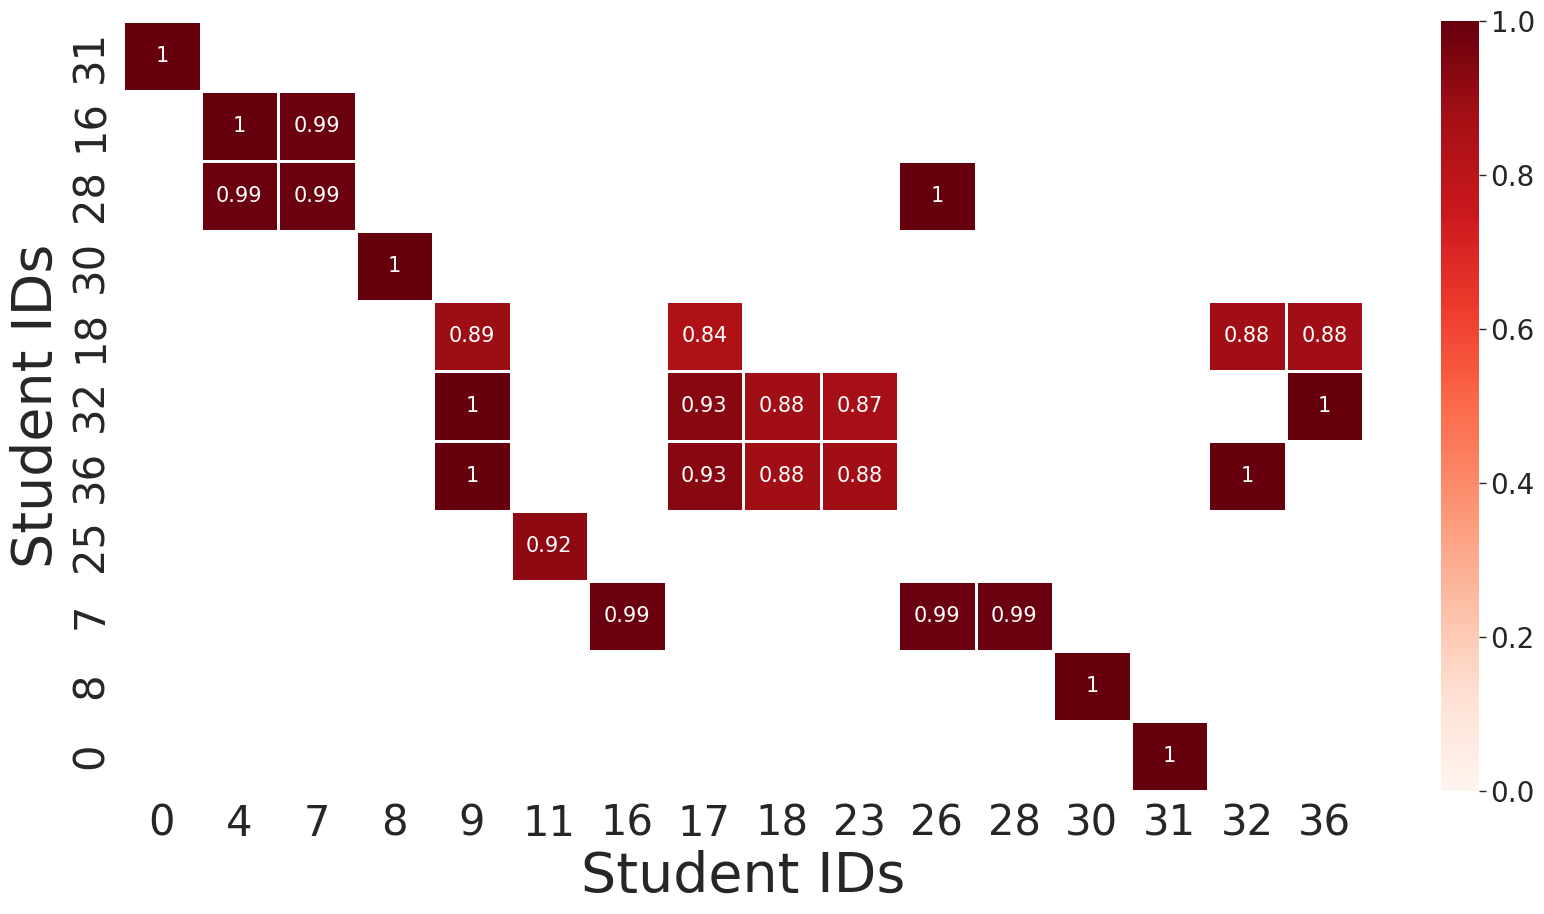

In [41]:
fig, axn = plt.subplots(1,1,figsize=(15,10))
sns.heatmap(df_overlap.round(2), annot=True, annot_kws={'fontsize':15},ax=axn,cmap='Reds', vmax=1, vmin=0, linewidths=1)
axn.set_xlabel(f"Session: {session}",fontsize=16)
axn.set_ylabel(f"Session: {session}",fontsize=16)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
axn.set_xlabel(f"Student IDs",fontsize=40)
axn.set_ylabel(f"Student IDs",fontsize=40)
cbar = axn.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.savefig(f'case_studies/plots/self_overlap_{course}_{session.split("_")[-1]}.png',dpi=400,bbox_inches='tight')

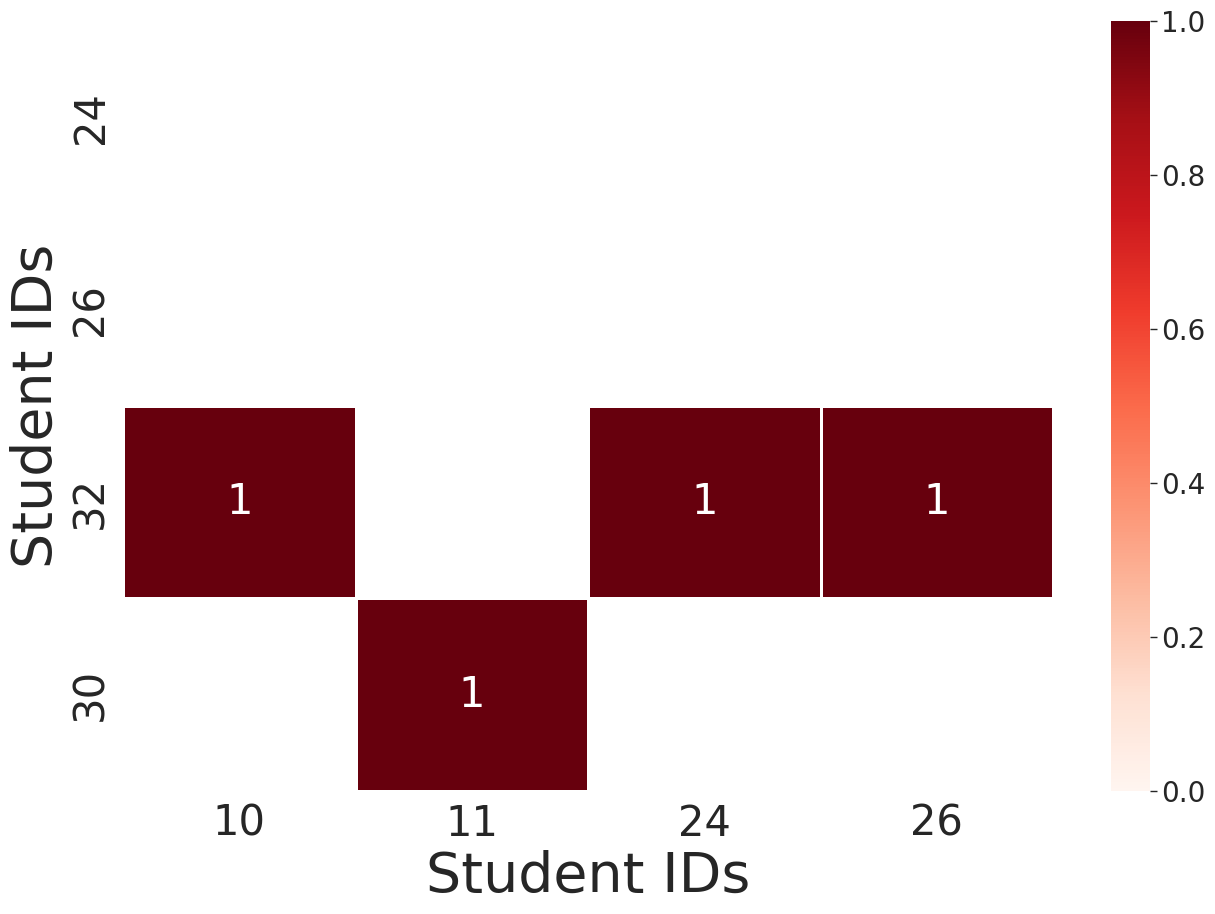

In [19]:
fig, axn = plt.subplots(1,1,figsize=(15,10))
df_overlap_matches= deepcopy(df_matching_method)
for col in df_overlap_matches.columns:
    for idx in df_overlap_matches.index:
        if (col in df_overlap.columns) and (idx in df_overlap.index):
            df_overlap_matches.loc[idx, col] = df_overlap.loc[idx,col]
        elif (idx in df_overlap.columns) and (col in df_overlap.index):
            df_overlap_matches.loc[idx, col] = df_overlap.loc[col,idx]
        else:
            df_overlap_matches.loc[idx, col] = np.nan
            
sns.heatmap(df_overlap_matches.round(2), annot=True, annot_kws={'fontsize':30},ax=axn,cmap='Reds', vmax=1, vmin=0, linewidths=1)
axn.set_xlabel(f"Session: {session}",fontsize=16)
axn.set_ylabel(f"Session: {session}",fontsize=16)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
axn.set_xlabel(f"Student IDs",fontsize=40)
axn.set_ylabel(f"Student IDs",fontsize=40)
cbar = axn.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.savefig(f'case_studies/plots/self_overlap_{course}_{session.split("_")[-1]}.png',dpi=400,bbox_inches='tight')

In [42]:
# find common map between overlap and embedding matching
df_overlap_melted = df_overlap.reset_index().melt(id_vars='index')
df_overlap_melted = df_overlap_melted[~df_overlap_melted['value'].isnull()]
df_overlap_melted['id_pair'] = df_overlap_melted.apply(lambda row: tuple(sorted([int(row['index']),int(row['variable'])])), axis=1)
df_overlap_melted = df_overlap_melted[['id_pair','value']]
df_overlap_melted

df_match_melted = df_matching_method.reset_index().melt(id_vars='index')
df_match_melted = df_match_melted[~df_match_melted['value'].isnull()]
df_match_melted['id_pair'] = df_match_melted.apply(lambda row: tuple(sorted([int(row['index']),int(row['variable'])])), axis=1)
df_match_melted = df_match_melted[['id_pair','value']]
df_match_melted

df_eligible_pairs = pd.merge(df_overlap_melted, df_match_melted, on='id_pair',suffixes=('_overlap','_match'))

df_eligible_pairs

,id_pair,value_overlap,value_match
0,"(4, 16)",0.995134,0.800730
1,"(9, 36)",0.999949,0.858774
2,"(11, 25)",0.918137,0.856029
3,"(17, 36)",0.930954,0.860253
4,"(26, 28)",1.000000,0.812450


In [137]:
# find common map between overlap and embedding matching
df_overlap_melted = df_overlap.reset_index().melt(id_vars='index')
df_overlap_melted = df_overlap_melted[~df_overlap_melted['value'].isnull()]
df_overlap_melted['id_pair'] = df_overlap_melted.apply(lambda row: tuple(sorted([int(row['index']),int(row['variable'])])), axis=1)
df_overlap_melted = df_overlap_melted[['id_pair','value']]
df_overlap_melted

df_match_melted = df_matching_method.reset_index().melt(id_vars='index')
df_match_melted = df_match_melted[~df_match_melted['value'].isnull()]
df_match_melted['id_pair'] = df_match_melted.apply(lambda row: tuple(sorted([int(row['index']),int(row['variable'])])), axis=1)
df_match_melted = df_match_melted[['id_pair','value']]
df_match_melted

df_eligible_pairs = pd.merge(df_overlap_melted, df_match_melted, on='id_pair',suffixes=('_overlap','_match'))

df_eligible_pairs

,id_pair,value_overlap,value_match
0,"(2, 35)",0.956510,0.195365
1,"(3, 32)",0.821217,0.160097
2,"(3, 33)",1.000000,0.138525
3,"(12, 36)",0.982976,0.137830
4,"(20, 26)",0.951355,0.113386
5,"(25, 29)",0.947668,0.164082


In [128]:
df_match_melted

,id_pair,value
0,"(2, 3)",0.183589
1,"(2, 35)",0.195365
11,"(3, 32)",0.160097
12,"(3, 33)",0.138525
22,"(12, 36)",0.137830
32,"(20, 26)",0.113386
42,"(23, 24)",0.130785
43,"(23, 25)",0.159238
52,"(24, 25)",0.111268
62,"(25, 29)",0.164082


In [129]:
df_overlap_melted

,id_pair,value
0,"(2, 35)",0.956510
11,"(3, 32)",0.821217
12,"(3, 33)",1.000000
23,"(7, 36)",0.818996
33,"(11, 36)",0.967712
34,"(11, 16)",0.807695
43,"(12, 36)",0.982976
55,"(11, 16)",0.807695
66,"(20, 26)",0.951355
77,"(22, 29)",0.861438


,index,variable,value
0,35,2,0.956510
1,32,2,NaN
2,33,2,NaN
3,36,2,NaN
4,16,2,NaN
...,...,...,...
115,11,36,0.967712
116,26,36,NaN
117,29,36,NaN
118,22,36,NaN
